# Introducción

## Modelo para análisis y recomendación de planes óptimos de Megaline

La compañía móvil Megaline no está satisfecha al ver que muchos de sus clientes utilizan planes heredados. Quieren desarrollar un modelo que pueda analizar el comportamiento de los clientes y recomendar uno de los nuevos planes de Megaline: Smart o Ultra.

## Objetivo

Desarrolla un modelo con la mayor exactitud posible. En este proyecto, el umbral de exactitud es 0.75. Usa el dataset para comprobar la exactitud.

### Tabla de contenidos
- Introducción: Presentación del problema y objetivo.
- Importanción, examinación y preparación de los datos: Se analiza la información proporcionada en el archivo `users_behavior.csv` para asegurarnos de que los datos no tengan alguna inconsistencia.
- Preparación de datos para entrenamiento, validación y testeo del modelo de clasificación: Se preparan los registros para poder ser consumidos por los modelos de clasificación y poder ejecutarlos evaluando su precisión.
- Prueba de cordura de los modelos: Evaluación de los distintos modelos para verificar le cumplimiento del objetivo del proyecto.
- Conclusiones.

# Importanción, examinación y preparación de los datos

Iniciaremos importando y abriendo el archivo csv `users_behavior.csv` ubicado en la carpeta `datasets` para conocer cual es la información que nos proporciona acerca de los clientes y validar alguna irregularidad que pudiera llegar a tener.

In [1]:
# Importando librerias
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.dummy import DummyClassifier

In [2]:
# Leyendo e imprimiendo archivo "CSV"
df = pd.read_csv('datasets/users_behavior.csv')
df

,calls,minutes,messages,mb_used,is_ultra
0,40.0,311.90,83.0,19915.42,0
1,85.0,516.75,56.0,22696.96,0
2,77.0,467.66,86.0,21060.45,0
3,106.0,745.53,81.0,8437.39,1
4,66.0,418.74,1.0,14502.75,0
...,...,...,...,...,...
3209,122.0,910.98,20.0,35124.90,1
3210,25.0,190.36,0.0,3275.61,0
3211,97.0,634.44,70.0,13974.06,0
3212,64.0,462.32,90.0,31239.78,0


Para el análisis de la información primero presentaremos la información de `df` lo cual nos ayudara a validar dos cosas:
- Nombre descriptivo de las columnas.
- El tipo de dato de cada columna.
- Encontrar valores nulos presentes en `df`.

In [3]:
# Información de "df"
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   calls     3214 non-null   float64
 1   minutes   3214 non-null   float64
 2   messages  3214 non-null   float64
 3   mb_used   3214 non-null   float64
 4   is_ultra  3214 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 125.7 KB


Como podemos observar el tipo de dato corresponde correctamente de acuerdo a la columna y la información que nos brinda, siendo `calls`, `minutes`, `messages`, `mb_used` tipo de dato `float64`, es decir, valores continuos que en el caso de las columnas `messages` y `calls` debe ser cambiado el tipo de dato de `float64` a `int64` y para el caso de `is_ultra`, podemos concluir que el nombre descriptivo no corresponde con la información ofrecida, por tal motivo debe ser cambiado por `plan`, así también aunque vemos un tipo de dato `int64` que de entrada parecería continuo, este es discreto pues nos indica el plan que tiene el usuario (`1 para Ultra y 0 para Smart`).

In [4]:
# Cambiando el nombre de la columna "is_ultra" por "plan" y el tipo de dato de "messages" y "calls" de "float64" a "int64"
df.rename(columns={'is_ultra':'plan'}, inplace=True)
df['calls'] = df['calls'].astype('int64')
df['messages'] = df['messages'].astype('int64')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   calls     3214 non-null   int64  
 1   minutes   3214 non-null   float64
 2   messages  3214 non-null   int64  
 3   mb_used   3214 non-null   float64
 4   plan      3214 non-null   int64  
dtypes: float64(2), int64(3)
memory usage: 125.7 KB


Como anteriormente se menciono, tenemos 4 variables (independientes) con valores continuos y una variable (discreta) con valores categóricos de acuerdo a la información proporcionada. Por tal motivo, validaremos dicha información en el `df` para asegurarnos de que así sea.

In [5]:
# Validando variables continuas y discretas
print('Variables independientes.')
print('Calls:',len(df['calls'].unique()))
print('Minutes:',len(df['minutes'].unique()))
print('Messages:',len(df['messages'].unique()))
print('Mb_used:',len(df['mb_used'].unique()))

print('------------')
print('Variable dependiente.')
print('Plan:',len(df['plan'].unique()))


Variables independientes.
Calls: 184
Minutes: 3144
Messages: 180
Mb_used: 3203
------------
Variable dependiente.
Plan: 2


De acuerdo con la información podemos asumir que las variables independientes y dependiente son correctas. Por tal motivo verificaremos si hay existencia de registros duplicados en `df`.

In [6]:
# Verificando duplicidad de registros
df.duplicated().sum()

0

Con lo anterior confirmamos la no existencia de registros duplicados y podemos concluir que nuestros datos estan preparados para ser analizados y procesados.

# Preparación de datos para entrenamiento, validación y testeo del modelo de clasificación

De acuerdo con las características del problema, los modelos adecuados para poder trabajar son aquellos que permiten la clasificación de datos y podemos estar seguros de esto pues el objetivo es identificar de acuerdo a las características del `df` cuál es el plan más adecuado para el usuario de acuerdo a su consumo.

Por esta razón podemos hacer dicha evaluación haciendo uso de tres modelos de clasificación distintos que son:
- Bosques aleatorios.
- Regresión logística.

Un aspecto importante a considerar es que para poder considerar el modelo con el mejor algoritmo de acuerdo a la problematica, debemos considerar la `exactitud` del modelo que se refiere a la precisión con la que categoriza de manera correcta los resultados de acuerdo a lo información proporcionada y por otro lado la `velocidad` que no es más que la demanda de recursos computacionales que requiera el algoritmo para procesar la información y proporcionar un resultado.

Por otro lado, también debemos considerar otro factor importante que es el `sobreajuste` y el `subajuste` que no es más que, respectivamente, la tendencia a un valor en específico no importando la información de entrada que se proporcione o la tendencia a la pseudoaleatoriedad en las respuestas proporcionadas, esto quiere decir que no hay un patrón o patrones a seguir a la hora de procesar y proporcionar respuestas.


## Segmentación de datos

Comenzaremos por la segmentación de los datos fuente en:
- Conjunto de entrenamiento que es un `60%` del set de datos.
- Conjunto de validación que es un `20%` del set de datos.
- Conjunto de pruebas que es un `20%` del set de datos.

Primero debemos generar dos conjuntos de datos, el primero llamado `features` contendrá todas las variables independientes, es decir, aquellos datos que se proporcionan como información para un resultado y el segundo llamado `target` que es el resultado de los datos `features`.

In [7]:
# Separando "features" y "target"
features = df.iloc[:,:-1]
target = df['plan']

Al tener estos valores, ya podemos generar los conjuntos de datos correspondientes para cada etapa a la que será sometido el modelo óptimo a la problemática. La idea principal consiste en hacer uso 2 veces de la función `train_test_split`; la primera creara dos conjuntos que son el conjunto de `entrenamiento` y un `conjuto auxiliar` que consiste de ser el equivalente a los conjuntos de `validación` y `pruebas` (`40%` del set de datos). Posteriormente este `conjunto auxiliar` será divido en dos conjutos por la mitad lo que equivaldría al `20%` y `20%` del set de datos total.

In [8]:
# Generando conjuntos de datos
X_train, X_auxiliar, y_train, y_auxiliar = train_test_split(features,target,test_size=0.4,random_state=12345)
X_valid, X_test, y_valid, y_test = train_test_split(X_auxiliar,y_auxiliar,test_size=0.5,random_state=12345)

Ahora validaremos que los conjuntos contengan la cantidad correcta de registros respecto del total.

In [9]:
# Validando porcentaje de los conjuntos
print('Training features:',len(X_train)/len(features),'Traning target:',len(y_train)/len(target))
print('Valid features:',len(X_valid)/len(features),'Valid target:',len(y_valid)/len(target))
print('Test features:',len(X_test)/len(features),'Test target:',len(y_test)/len(target))

Training features: 0.5998755444928439 Traning target: 0.5998755444928439
Valid features: 0.2000622277535781 Valid target: 0.2000622277535781
Test features: 0.2000622277535781 Test target: 0.2000622277535781


De acuerdo al resultado, podemos observar que cada conjunto contiene la cantidad que le debe corresponder, es decir, el `conjunto de entrenamiento` con un `60%`, el `conjunto de validación` con un `20%` y el `conjunto de prueba` con un `20%` del total de registros.

## Testeo de los modelos de clasificación

Cada uno de los modelos de clasificación cuenta con ventajas y desventajas, por tal motivo, ejecutaremos pruebas de rendimiento para cada modelo con la intención de evaluar su calidad al momento de predecir resultados basado en su entrenamiento.

### Modelo: Bosques aleatorios

Comenzaremos con el modelo de `Bosques aleatorios`. Para este modelo debemos considerar sus hiper parámetros que son aquellos datos específicos que permiten modelar de forma correcta la estructura de entrenamiento de acuerdo con los datos de entrada que se le proporcionen (`features`).

En específico nos centraremos en los siguiente hiper parámetros:
- `n_estimators`: número de árboles a implementar en el modelo.
- `criterion`: función que permite cuantificar la calidad de los segmentos generados.
- `max_depth`: máxima profundidad del árbol.
- `min_samples_split`: la cantidad mínima de muestras requeridas para dividir un nodo interno.
- `min_samples_leaf`: la cantidad mínima de muestras para poder estar en un nodo.

Procederemos con la generación del modelo evaluando la calidad de predicción.

In [10]:
# Creación del modelo
best_score = 0
best_estimator = 0
criterion = ''
max_depth = 0

criterions = ['gini', 'entropy']
for estimators in range(10,201,10):
    for crit in criterions:
        for rest in range(2,15):
            rfc_model = RandomForestClassifier(random_state=12345,
                                               n_estimators=estimators,
                                               criterion=crit,
                                               max_depth=rest,
                                               min_samples_split=rest,
                                               min_samples_leaf=rest)
            rfc_model.fit(X_train,y_train)
            score = rfc_model.score(X_valid,y_valid)
            if score > best_score:
                best_score = score
                best_estimator = estimators
                criterion = crit
                max_depth = rest

print("Accuracy del mejor modelo en el conjunto de validación (n_estimators = {}, criterion = {}, [max_depth,min_samples_split,min_samples_leaf] = {} ): {}".format(best_estimator, criterion, rest, best_score))
    

Accuracy del mejor modelo en el conjunto de validación (n_estimators = 160, criterion = entropy, [max_depth,min_samples_split,min_samples_leaf] = 14 ): 0.807153965785381


De acuerdo con el algoritmo, la mejor marca es para `n_estimators = 160`, `criterion = entropy`, `max_depth, min_samples_split y min_samples_leaf = 14` con una precisión del `80%`. Por tal motivo, consideraremos estos valores como los más adecuados para el model de `Bosques aleatorios`. Por esta razón haremos uso de estos valores para sus hiper parámetros.

In [11]:
# Construyendo el modelo final de "bosques aleatorios"
rfc_model = RandomForestClassifier(random_state=12345,
                                   n_estimators=160, 
                                   criterion='entropy', 
                                   max_depth=14,
                                   min_samples_split=14,
                                   min_samples_leaf=14)
rfc_model.fit(X_train,y_train)
rfc_score = rfc_model.score(X_valid,y_valid)

Posteriormente trabajaremos con el algoritmo de clasificación de `regresión logística`.

### Modelo: Regresión logística

Este modelo requiere de un hiper parámetro a considerar para un buen modelado y es `solver`, que ayuda al agoritmo a reconocer de mejor forma las características de entrada que se le proporcionan; como opciones tenemos las siguientes:
- `liblinear`: Se aplica cuando se tiene un dataset pequeño ademas de una categorización binaria, es decir, uno contra el resto de resultados.
- `newton-cg`, `sag`, `saga` and `lbfgs`: Se aplican cuando se tienen problemas de multiclase, es decir, que la clasificación va más allá de 2 clases de resultados.
- `newton-cholesky`: Se usa cuando dentro del mismo dataset hay información categorica.

Por lo anterior y debido a las características de los datos de entrada podemos determinar que `liblinear` es la opción adecuada por lo siguiente:
- Tenemos un dataset reducido.
- Tenemos una categorización binaria, lo que podría considerarse una categoría contra el resto.

Una vez teniendo estos datos justificados, iniciaremos con el modelado.

In [12]:
# Creación del modelo
lr_model = LogisticRegression(random_state=12345,solver='liblinear')
lr_model.fit(X_train,y_train)
lr_score = lr_model.score(X_valid,y_valid)
print('La precisión obtenida en el algoritmo de "Regresión logística es:"',lr_score)

La precisión obtenida en el algoritmo de "Regresión logística es:" 0.7091757387247278


Como podemos ver, el modelo con mejor precisión hasta este punto es `bosques aleatorios` sin embargo hay un modelo más que debemos tomar en consideración pues puede ser aplicable tanto para problemas de regresión como de clasificación y es el caso de `árboles de decisión`.

### Modelo: Árboles de decisión

Para este modelo, debemos considerar la máxima profundidad del árbol a construir por el modelo y es el hiper parámetro `max_depth`.

In [13]:
# Creación del modelo
best_score = 0
best_depth = 0
criterion = ''
min_samples_split = 0
criterions = ["gini", "entropy"]

for depth in range(1,15):
    for crit in criterions:
        for rest in range(2,15):
            dtc_model = DecisionTreeClassifier(random_state=12345,
                                               max_depth=depth, criterion=crit, 
                                               min_samples_split=rest, min_samples_leaf=rest)
            dtc_model.fit(X_train,y_train)
            score = dtc_model.score(X_valid,y_valid)
            if score > best_score:
                best_score = score
                best_depth = depth
                criterion = crit
                min_samples_split = rest
        
print("Accuracy del mejor modelo en el conjunto de validación (max_depth = {}, criterion = {}, [min_samples_split, min_samples_leaf] = {}): {}".format(best_depth, criterion, min_samples_split, best_score))
    

Accuracy del mejor modelo en el conjunto de validación (max_depth = 6, criterion = entropy, [min_samples_split, min_samples_leaf] = 4): 0.7900466562986003


De acuerdo con la información que nos proporciona este algoritmo, la máxima profundidad que arroja el mejor resultado se genera a partir de `max_depth = 6`, `criterion = entropy`, `min_samples_split y min_samples_leaf = 4` dando una eficiencia del `79%`. Construiremos el modelo con este parámetro fijo.

In [14]:
# Construyendo el modelo final de "árboles de decisión"
dtc_model = DecisionTreeClassifier(random_state=12345,max_depth=6,criterion='entropy',
                                   min_samples_split=4, min_samples_leaf=4)
dtc_model.fit(X_train,y_train)
dtc_score = dtc_model.score(X_valid,y_valid)

In [15]:
# Graficando resultados comparativos entre los tres modelos
results = pd.DataFrame(data={'Bosques aleatorios': rfc_score*100,
                             'Árboles de decisión': dtc_score*100,
                             'Regresión logística': lr_score*100},index=[0])
results

,Bosques aleatorios,Árboles de decisión,Regresión logística
0,79.62675,79.004666,70.917574


<AxesSubplot:ylabel='% score'>

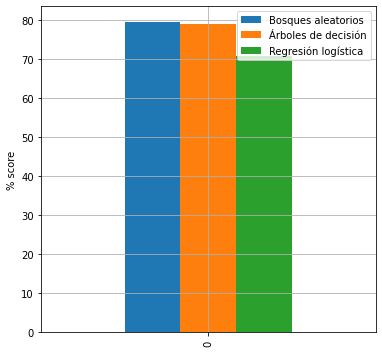

In [16]:
# Graficando resultados
results.plot.bar(grid=True,figsize=(6,6),ylabel='% score')

De acuerdo con el gráfico, el modelo de `Bosques aleatorios` se posiciona como el modelo con la mayor exactitud posible con hiper parámetros `n_estimators = 160` de acuerdo con el `conjunto de validación`. El hecho de no tener un desempeño aun más alto puede deberse a la cantidad de registros con los que se esta entrenando el modelo, puesto que de los `3214` unicamente se están utilizando `1928` registros para su entrenamiento.

Ahora procederemos con la evaluación de los modelos haciendo uso del `conjunto de prueba`, mantendremos la misma dinámica para concer el desempeño de cada uno.

In [17]:
# Ejecutando y evaluando modelos con el "conjunto de pruebas"
rfc_test_score = rfc_model.score(X_test,y_test)
lr_test_score = lr_model.score(X_test,y_test)
dtc_test_score = dtc_model.score(X_test,y_test)

In [18]:
# Creando "new_results" a partir de la evaluación del "conjunto de pruebas"
new_results = pd.DataFrame(data={'Bosques aleatorios': rfc_test_score*100,
                                 'Árboles de decisión': dtc_test_score*100,
                                 'Regresión logística': lr_test_score*100,},index=[0])
new_results

,Bosques aleatorios,Árboles de decisión,Regresión logística
0,80.404355,77.916019,68.895801


<AxesSubplot:ylabel='% score'>

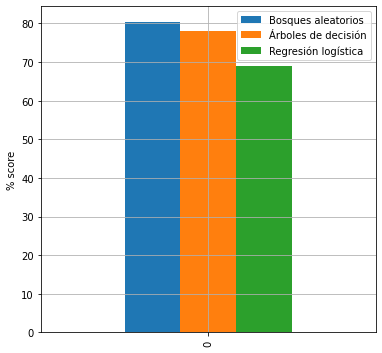

In [19]:
# Graficando nuevos resultados
new_results.plot.bar(grid=True,figsize=(6,6),ylabel='% score')

In [20]:
pd.DataFrame(data={'Bosques aleatorios': [rfc_test_score*100,rfc_score*100],
                   'Regresión logística': [lr_test_score*100,lr_score*100],
                   'Árboles de decisión': [dtc_test_score*100,dtc_score*100]},index=["Test","Valid"])

,Bosques aleatorios,Regresión logística,Árboles de decisión
Test,80.404355,68.895801,77.916019
Valid,79.626750,70.917574,79.004666


De acuerdo con el resultado, podemos observar que en la validación de desempeño de cada modelo, `Bosques aleatorios` se posiciona como el modelo con mejor desempeño de los tres, incluso llegando al punto de que tanto `Regresión logística` como `Árboles de decisión` disminuyerón su desempeño.

Una vez sabiendo el desempeño de los distintos modelos, vamos a ejecutar una prueba de cordura con la intención de cumplir el objetivo anteriormente planteado que dice que buscamos una exactitud de al menos `75%`.

# Prueba de cordura de los modelos

Una prueba de cordura en el desarrollo de software se refiere a un proceso de validación al momento de hacer implementaciones extra a un servicio o aplicación ya existentes, es decir, las pruebas de cordura permiten decidir si las funcionalidades nuevas serán introducidas en el código una vez que se sabe que estas no afectarían las funcionalidades ya implementadas. Basicamente las pruebas de cordura constan de 3 pasos simples:
- Identificación: Se deben tener claro cuales son las funcionalidades nuevas y sus características.
- Evaluación: Las nuevas fucionalidades son sometidas al proceso de evaluación para validar el correcto funcionamiento de las mismas.
- Prueba: Se prueba la funcionalidad del servicio/aplicación nueva para validar su integración.

Así también, las pruebas de cordura, son aplicadas bajo las siguientes condiciones:
- Debe ser ejecutaba bajo versiones relativamente estables.
- No requiere documentación.
- Las pruebas de cordura no requieren scripts.
- Una cantidad limitada de fucionales son cubiertas por esta prueba.
- Usualmente son evaluadas por testers.
- Las pruebas de cordura son pruebas estrechas y profundas de tipos de pruebas de regresión.
- Actua como jurado respecto a la implementación de la nueva funcionalidad.

Para el caso de los modelos implementados anteriormente, haremos uso del modelo `DummyClassifier`, esto nos permitira medir el desempeño de los modelos de machine learning contra un modelo pseudoaleatorio donde el hiper parámetro a considerar es `strategy` con los siguientes valores posibles:
- `most_frecuent`: retorna la clase con mayor frecuencia.
- `prior`: retorna la clase con mayor prioridad (la de mayor frecuencia).
- `stratified`: muestra aleatoriamente vectores one_hot de una distribución multinomial parametrizada por las probabilidades previas de la clase empírica.
- `uniform`: genera predicciones aleatorias uniformes de la lista de clases observadas en "y".
- `constant`: siempre retorna la etiqueta proporcionada por le usuario (no es muy funcional para esta prueba).

In [21]:
# Prueba de cordura
strategies = ['most_frequent', 'stratified', 'uniform']
best_score = 0
strategy = ''
for strat in strategies:
    dc = DummyClassifier(strategy=strat)
    dc.fit(X_train,y_train)
    score = dc.score(X_test,y_test)
    if score > best_score:
        best_score = score
        strategy = strat
        
print("Accuracy del modelo Dummy Classifier en el conjunto de prueba (strategy = {}): {}".format(strategy, best_score))

Accuracy del modelo Dummy Classifier en el conjunto de prueba (strategy = most_frequent): 0.6842923794712286


In [22]:
# Creando el modelo con el mejor desempeño
dc = DummyClassifier(strategy='most_frequent')
dc.fit(X_train,y_train)
dc_test_score = dc.score(X_test,y_test)

pd.DataFrame(data={'Bosques aleatorios': rfc_test_score*100,
                   'Regresión logística': lr_test_score*100,
                   'Árboles de decisión': dtc_test_score*100,
                   'Dummy Classifier': dc_test_score*100},index=["Test"])

,Bosques aleatorios,Regresión logística,Árboles de decisión,Dummy Classifier
Test,80.404355,68.895801,77.916019,68.429238


Como podemos observar en la prueba de cordura, todos los modelos superar aunque sea minimamente, el desempeño de `DummyClassifier` lo cual en el estricto sentido podría decirse que cualquier modelo es apto para ser usado en este ejercicio.

# Conclusiones

Al implementar el modelo de `Bosques aleatorios` observamos una precisión significativa frente a `Regresión logística` y una sutil pero al final de todo precisión superior frente a `Árboles de decisión` con un porcentaje de `80.4%` que es superior al objetivo buscando inicialmente.

Este objetivo fue logrado debido a que se considerarón los hiper parámetros de forma correcta, es decir, al asignar `160` a `n_estimators`, `criterion = entropy`, `max_depth, min_samples_split y min_samples_leaf = 14` y `12345` a `random_state` (que es una pseudoaleatoriedad que se mantiene a lo largo de la ejecución) se logro la mayor precisión posible en el modelo implementado. Podemos añadir también que es posible mejorar esta `exactitud` al tomar en cuenta otras hiper parámetros y aumentar la cantidad de registros de entrenamiento pues a mayor volumen de datos, el algoritmo podra construir matematicamente un mejor modelo.

Este proyecto me ayudo a sentar las bases de `Machine Learning` permitiendo identificar que tipo de problematica a resolver se tiene dependiendo de los datos proporcionados, así también, hacer el trabajo de preprocesamiento de datos para dejar listo los registros para entrenamiento y testeo, eso en conjunto con los temas de sprint anteriores permitiría construir modelos de inteligencia artificial más eficientes que pueden consumir datos de distintas fuentes o bases de datos y que también podrián ser retroalimentados con datos obtenidos de la web.